# First order Nomoto model for ship maneuvering dynamics
> Implementation of the so called first order Nomoto model for ship maneuvering dynamics

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [simulation, dynamics, manoeuvring, system identification, nomoto]
- image: images/nomoto.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

The first order Nomoto model can be written as:
$$ K \cdot \delta=r+T_{1} \cdot \dot{r}+T_{2} \cdot \ddot{r} $$
where $r$ is yaw rate with its time derivatives and $\delta$ is the rudder angle. $K$, $T_{1}$
 and $T_{1}$ are the coefficients describing the hydrodynamics of the ship.
 
 For slow manoeuvres this equation can be further simplified by removing the $\ddot{r}$ term:
 $$ K \cdot \delta=r+T_{1} \cdot \dot{r}$$

In [1]:
#hide
import warnings
warnings.filterwarnings("ignore")

In [2]:
#collapse
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Math
from scipy.optimize import least_squares
import altair as alt

The simulation model can be expressed in Python as a state space model:

In [3]:
def calculate_r1d(K,T_1,delta,r):
    return (K*delta - r)/T_1 
    
def nomoto(t,states):
    """
    Simulation model for heading and yaw rate using Nomoto with only K and T_1
    """
    # states:
    psi = states[0]
    r = states[1]
    
    r1d_ = calculate_r1d(K=K, T_1=T_1, delta=delta, r=r)
    d_states_dt = np.array([r,r1d_])
    return d_states_dt

## Simulate a pull out manoeuvre
Simulating a simple pull out manoeuvre:

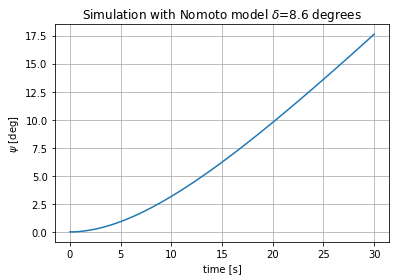

In [4]:
#collapse
K = 0.1
delta = 0.15
T_1 = 10

states_0 = np.array([0,0])
t = np.linspace(0,30,100)

sol = solve_ivp(fun = nomoto,t_span=[t[0],t[-1]],t_eval=t, y0 = states_0)
psi = sol.y[0,:]
r = sol.y[1,:]

fig,ax=plt.subplots()
ax.plot(t,np.rad2deg(psi));
ax.grid(True)
ax.set_title('Simulation with Nomoto model $\delta$=%0.1f degrees' %np.rad2deg(delta))
ax.set_ylabel('$\psi$ [deg]')
ax.set_xlabel('time [s]');

## Simulate a ZigZag test
A ZigZag test can be simulated by adding an auto pilot to the model:

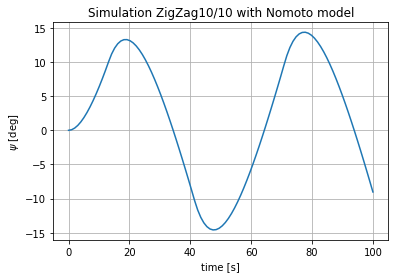

In [5]:
#collapse
def nomoto_zigzag(t, states, K, T_1, angle=np.deg2rad(10)):
    """
    Simulation model for heading and yaw rate using Nomoto with only K and T_1
    Also including an autopilot for ZigZag test:
    """
    
    
    # states: 
    psi = states[0]
    r = states[1]
    
    #ZigZag autopilot:
    sign=-1
    psi_pluss = ((psi>=0) and (psi<angle))
    psi_minus = ((psi>=-angle) and (psi<=0))
    
    if (
        (psi_pluss and (r>=0)) |
        (psi<-angle) |
        (psi_minus and (r>=0))
        
        
    ):
        sign=1   
    delta_=sign*delta
    
    #Nomoto equation:
    r1d_ = (K*delta_ - r)/T_1 
    d_states_dt = np.array([r,r1d_])
    
    return d_states_dt

## Simulation:
K = 0.2
delta = 0.15
T_1 = 10
angle=np.deg2rad(10)
states_0 = np.array([0,0])
t = np.linspace(0,100,100)

sol = solve_ivp(fun = nomoto_zigzag,t_span=[t[0],t[-1]],t_eval=t, y0 = states_0, args=(K,T_1,angle))
psi = sol.y[0,:]
r = sol.y[1,:]

fig,ax=plt.subplots()
ax.plot(t,np.rad2deg(psi));
ax.grid(True)
ax.set_title('Simulation ZigZag%0.0f/%0.0f with Nomoto model' % (np.rad2deg(angle),np.rad2deg(angle)))
ax.set_ylabel('$\psi$ [deg]')
ax.set_xlabel('time [s]');

## Perform simple system identification
Is this very simple model good to describe the dynamics for one "real" ZigZag model test? This will be investigated by first loading some model test data and then fitting the simple Nomoto model to this data. Model test data:

In [6]:
#collapse
df = pd.read_csv('example_zigzag.csv', sep=';', index_col=0)
df['delta']*=-1  # Nomoto has another sign convention
df['delta_deg']=np.rad2deg(df['delta'])
df['psi_deg']=np.rad2deg(df['psi'])

display(df.head())

source = df.reset_index()
alt.layer( 
    alt.Chart(source).mark_line(color='blue').encode(x='time',y='psi_deg'),                                         
    alt.Chart(source).mark_line(color='orange').encode(x='time',y='delta_deg')
    
         ,).interactive()

,delta,x0,y0,psi,r,delta_deg,psi_deg
time,,,,,,,
0.00,0.008786,-25.137978,-0.063029,-0.001346,0.000000,0.503417,-0.077114
0.02,0.008786,-25.103222,-0.063109,-0.001346,-0.002182,0.503417,-0.077114
0.04,0.008786,-25.068771,-0.063222,-0.001433,-0.002182,0.503417,-0.082114
0.06,0.008786,-25.034290,-0.063301,-0.001433,0.000000,0.503417,-0.082114
0.08,0.008786,-24.999577,-0.063382,-0.001433,0.000000,0.503417,-0.082114


alt.LayerChart(...)

When examing this test a bit closer, it seems that:
* The first rudder order is at time=1.15 s
* There is a 0.5 degrees initial rudder angle (to get the model on a straight course).
* There is also a very small yaw rate at the start. (But this can be handled by using this as the initial state in the simulations).

To simplify further analysis the initial part is removed and the rudder angle is "zeeroed" around the initial value.

In [7]:
#collapse
df['delta']-=df.iloc[0]['delta']
df['delta_deg']=np.rad2deg(df['delta'])
df.index-=df.iloc[0].name
mask=df.index>1.15
df=df.loc[mask]

We attempt to estimate the coefficients using least square fit. We then need to first get the $\dot{r}$ by performing numerical derivation:

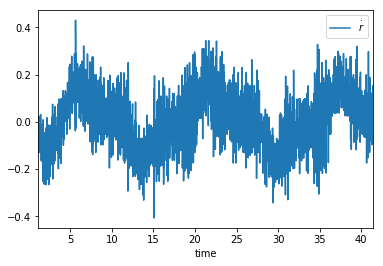

In [8]:
#collapse
df['r1d']=np.gradient(df['r'],df.index)
fig,ax=plt.subplots()
df.plot(y='r1d',ax=ax, label='$\dot{r}$');

The data is now very noisy but we try to do the leas sqyare fit anyway:

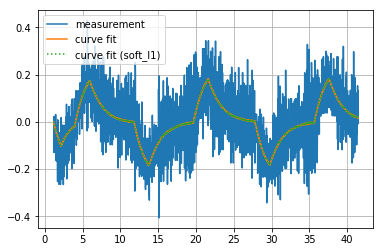

In [9]:
#collapse

def estimator(parameters, X):
    delta=X['delta']
    r=X['r']
    
    K=parameters[0]
    T_1=parameters[1]
    
    return calculate_r1d(K=K, T_1=T_1, delta=delta, r=r)  
    
def error_function(x, X, ys):
    return ys-estimator(x,X)

data = df.copy()
ys=data.pop('r1d')
X=data.copy()

kwargs={
    'X':X,
    'ys':ys,
}

initial_guess=[1,1]
result = least_squares(fun=error_function, x0=initial_guess,
                       kwargs=kwargs)

result_soft_l1 = least_squares(fun=error_function, x0=initial_guess,
                       kwargs=kwargs, loss='soft_l1')

y_pred = estimator(parameters=result.x, X=X)
y_pred_soft_l1 = estimator(parameters=result_soft_l1.x, X=X)

fig,ax=plt.subplots()
time=data.index
ax.plot(time,ys, label='measurement')
ax.plot(time,y_pred, label='curve fit');
ax.plot(time,y_pred, ':', label='curve fit (soft_l1)');
ax.legend()
ax.grid(True)

In [21]:
#hide_input
K_=result.x[0]
T_1_=result.x[1]
display(Math('K=%0.2f, T_1=%0.2f' % (K_,T_1_)))

<IPython.core.display.Math object>

We try to simulate with the estimated coefficients:

In [11]:
#collapse
def nomoto_replay(t, states, K, T_1, deltas):
    
    # states:
    psi = states[0]
    r = states[1]
    
    i=np.argmin(np.abs(deltas.index-t))
    delta=deltas.iloc[i]
    
    r1d_ = calculate_r1d(K=K, T_1=T_1, delta=delta, r=r)
    
    d_states_dt = np.array([r,r1d_])
    
    return d_states_dt

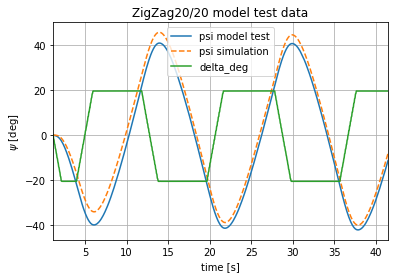

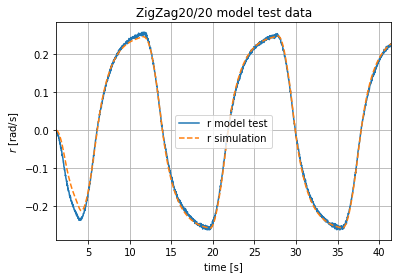

In [12]:
#collapse

## Simulate:
r0 = df.iloc[0]['r']
states_0 = np.array([0,r0])
K_=result.x[0]
T_1_=result.x[1]
deltas=data['delta']

sol = solve_ivp(fun = nomoto_replay,t_span=[time[0],time[-1]],t_eval=time, y0 = states_0, 
                args=(K_,T_1_,deltas))


df_simulation_replay=pd.DataFrame(index=df.index)
df_simulation_replay['psi'] = sol.y[0,:]
df_simulation_replay['r'] = r = sol.y[1,:]
df_simulation_replay['psi_deg']=np.rad2deg(df_simulation_replay['psi'])

## Plotting:
fig,ax=plt.subplots()
df.plot(y='psi_deg', label='psi model test', ax=ax)
df_simulation_replay.plot(y='psi_deg', label='psi simulation', style='--', ax=ax)
df.plot(y='delta_deg', ax=ax)

ax.set_ylabel('$\psi$ [deg]')
ax.set_xlabel('time [s]');
ax.grid(True)
ax.set_title('ZigZag20/20 model test data')

fig,ax=plt.subplots()
df.plot(y='r', label='r model test', ax=ax)
df_simulation_replay.plot(y='r', label='r simulation', style='--', ax=ax)

ax.set_ylabel('$r$ [rad/s]')
ax.set_xlabel('time [s]');
ax.grid(True)
ax.set_title('ZigZag20/20 model test data');

So this simple Nomoto model seem to capture the dynamics pretty well. It can be noted that the initial part of the test, with the first overshoot is not captured so well.

## Also using $T_2$
Can also including the $T_2$ coefficient in the Nomoto's equation (above) make this even better? The first challange is then to determine the $\ddot{r}$ using numerical derivation which is not so easy:

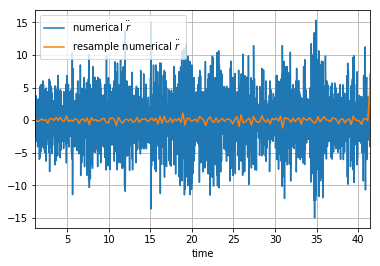

In [13]:
#collapse
df['r2d'] = np.gradient(df['r1d'], df.index)

df_=df.copy()
df_.index = pd.TimedeltaIndex(df_.index,unit='s')
df_=df_.resample('0.25S').mean()
df_.index=df_.index.total_seconds()

fig,ax=plt.subplots()
df.plot(y='r2d', ax=ax, label='numerical $\ddot{r}$')
df_.plot(y='r2d', ax=ax, label='resample numerical $\ddot{r}$')
ax.grid(True)

It seems that the estimated $\ddot{r}$ signal is not carying much usefull information. But we try to use it anyway:

In [14]:
#collapse
def calculate_r2d(K,T_1,T_2,delta,r,r1d):
    # K*delta = r + T_1*r1d + T_2*r2d
    #--> r2d = (K*delta - r - T_1*r1d)/T_2
    return (K*delta - r - T_1*r1d)/T_2

def estimator_T2(parameters, X):
    delta=X['delta']
    r=X['r']
    r1d=X['r1d']
    
    K=parameters[0]
    T_1=parameters[1]
    T_2=parameters[2]
        
    return calculate_r2d(K=K, T_1=T_1, T_2=T_2, delta=delta, r=r, r1d=r1d)  
    
def error_function_T2(x, X, ys):
    return ys-estimator_T2(x,X)

df['r2d'] = np.gradient(df['r1d'], df.index)
data2 = df.copy()
ys2=data2.pop('r2d')
X2=data2.copy()


kwargs={
    'X':X2,
    'ys':ys2,
}

initial_guess_T2=[1,1,1]
result_T2 = least_squares(fun=error_function_T2, x0=initial_guess_T2,
                       kwargs=kwargs)


In [22]:
#hide_input
K_=result_T2.x[0]
T_1_=result_T2.x[1]
T_2_=result_T2.x[2]

display(Math('K=%0.2f, T_1=%0.2f, T_2=%0.2f' % (K_,T_1_,T_2_)))

<IPython.core.display.Math object>

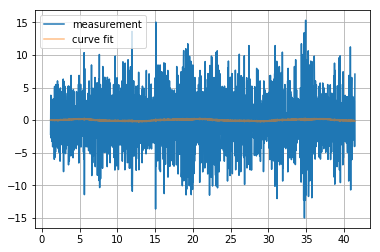

In [16]:
#collapse
y_pred = estimator_T2(parameters=result_T2.x, X=X2)

fig,ax=plt.subplots()
time=data.index
ax.plot(time,ys2, label='measurement')
ax.plot(time,y_pred,label='curve fit', alpha=0.5);
ax.legend()
ax.grid(True)

If we look at the predicted $\ddot{r}$ and compare to rudder actions it seems that there is some information after all:

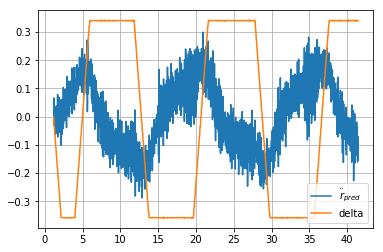

In [17]:
#collapse
fig,ax=plt.subplots()
time=data.index

ax.plot(time,y_pred,label='$\ddot{r}_{pred}$');
ax.plot(time,df['delta'])
ax.legend()
ax.grid(True)

In [18]:
#collapse
def nomoto_replay_T2(t, states, K, T_1, T_2, deltas):
    
    # states:
    # [psi, r, r1d]
    
    psi = states[0]
    r = states[1]
    r1d = states[2]
    
    
    i=np.argmin(np.abs(deltas.index-t))
    delta=deltas.iloc[i]
    
    r2d_ = calculate_r2d(K=K, T_1=T_1, T_2=T_2, delta=delta, r=r, r1d=r1d)
    
    d_states_dt = np.array([r,r1d,r2d_])
    
    return d_states_dt

In [19]:
#collapse

states_0 = np.array([0,r0,0])
K_=result_T2.x[0]
T_1_=result_T2.x[1]
T_2_=result_T2.x[2]

deltas=data2['delta']

sol = solve_ivp(fun = nomoto_replay_T2,t_span=[time[0],time[-1]],t_eval=time, y0 = states_0, 
                args=(K_,T_1_,T_2_,deltas))


df_simulation_replay_T2=pd.DataFrame(index=df.index)
df_simulation_replay_T2['psi'] = sol.y[0,:]
df_simulation_replay_T2['r'] = r = sol.y[1,:]
df_simulation_replay_T2['psi_deg']=np.rad2deg(df_simulation_replay_T2['psi'])

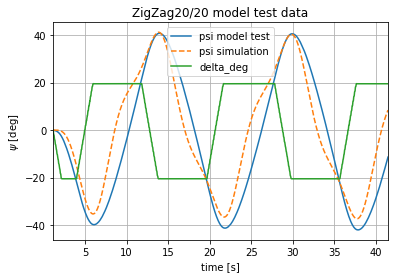

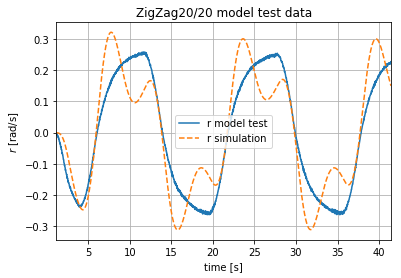

In [20]:
#collapse
fig,ax=plt.subplots()
df.plot(y='psi_deg', label='psi model test', ax=ax)
df_simulation_replay_T2.plot(y='psi_deg', label='psi simulation', style='--', ax=ax)
df.plot(y='delta_deg', ax=ax)

ax.set_ylabel('$\psi$ [deg]')
ax.set_xlabel('time [s]');
ax.grid(True)
ax.set_title('ZigZag20/20 model test data')

fig,ax=plt.subplots()
df.plot(y='r', label='r model test', ax=ax)
df_simulation_replay_T2.plot(y='r', label='r simulation', style='--', ax=ax)

ax.set_ylabel('$r$ [rad/s]')
ax.set_xlabel('time [s]');
ax.grid(True)
ax.set_title('ZigZag20/20 model test data');

...so this was not an improvement, but perhaps I've made something wrong here?